In [7]:
#Lauren Jachimczyk
#ML in Finance HW 3

# 1. (15 points) You are managing a portfolio with two assets. Asset A has an expected return of 10%
# with a standard deviation of 5%, and Asset B has an expected return of 15% with a standard
# deviation of 8%. The correlation between their returns is 0.6. You have allocated 60% of your
# capital to Asset A and 40% to Asset B. What is the expected return and standard deviation of
# your portfolio?
import math
expected_return_1 = (0.10*0.60)+(0.15*0.40)
std_dev_1 = math.sqrt((0.60*0.05)**2+(0.40*0.08)**2+(2*0.60*0.40*0.6*0.05*0.08))
print(f'1. The expected return is {expected_return_1} and standard deviation is {std_dev_1}')


# 2. (10 points) The risk-free rate is 3%, the expected return on the market is 9%, and a stock has a
# beta of 1.5. According to CAPM, what is the expected return of the stock?
expected_return_2 = 0.03+(1.5*(0.09-0.03))
print(f'2. The expected return is {expected_return_2} according to CAPM')

# 3. (10 points) Figure on the left shows
# three portfolios A, B, and C which have
# the same average annual return of 15%.
# All three have the same volatility of
# 20%. Are all three portfolio managers
# equally talented? If you are to invest
# your money, which one would you
# choose?
print('3. I would invest my money with Portfolio Manager A - since all portfolios have the same expected return'
      ' the portfolio with the lowest beta would be the best option. Beta is a measure of the sensitivity to market'
      ' movements and how volatile a portfolio is relative to the market, so ideally a lower beta is better.')

# 4. (15 points) Hedge Fund ABC had an average annualized return of 14.2% and a return standard
# deviation of 7.3% from January 1990 to December 2010. Its estimated beta during this period
# was 0.12. Given that the risk-free rate was 4% and the market return averaged 9% during this
# period, did the fund manager perform more than expected according to the CAPM? If yes, what
# was the manager’s alpha?
expected_return_4 = 0.04+(0.12*(0.09-0.04))
actual_return = 0.142
alpha = actual_return - expected_return_4
print(f'4. The expected return during this period is {expected_return_4:2%} therefore the fund manager did'
     f' better than expected, with an actual return of 14.2% an alpha of {alpha:.2%}')



1. The expected return is 0.12 and standard deviation is 0.055461698495448186
2. The expected return is 0.12 according to CAPM
3. I would invest my money with Portfolio Manager A - since all portfolios have the same expected return the portfolio with the lowest beta would be the best option. Beta is a measure of the sensitivity to market movements and how volatile a portfolio is relative to the market, so ideally a lower beta is better.
4. The expected return during this period is 4.600000% therefore the fund manager did better than expected, with an actual return of 14.2% an alpha of 9.60%


In [26]:
# 5. (50 points) Write a Python program to check if a weighted combination of assets lies on the
# efficient frontier. The program should be able to handle any number of assets and should read the
# asset weights, expected returns, and covariance matrix from an Excel file. You are allowed to use
# optimization packages such as SciPy or CVXPY for the optimization process. Direct plotting
# of the efficient frontier using libraries like PyPortfolioOpt, or other similar tools is
# not allowed.
import pandas as pd
import numpy as np 
portfolio_raw_data = pd.read_excel('portfolio.xlsx')
portfolio_raw_data = portfolio_raw_data.set_index('Date')
# portfolio_raw_data.head()

num_securities = portfolio_raw_data.shape[1]
print(f"The portfolio has {num_securities} securities.")
user_input_weights = []

for i in range(num_securities):
    weight = float(input(f"Enter the weight for {portfolio_raw_data.columns[i]} (e.g., 0.2 for 20%): "))
    user_input_weights.append(weight)




The portfolio has 9 securities.
Enter the weight for DIS (e.g., 0.2 for 20%): 0.2
Enter the weight for GE (e.g., 0.2 for 20%): 0.1
Enter the weight for GILD (e.g., 0.2 for 20%): 0.1
Enter the weight for GOOGL (e.g., 0.2 for 20%): 0.3
Enter the weight for KMI (e.g., 0.2 for 20%): 0.03
Enter the weight for OIL (e.g., 0.2 for 20%): 0.07
Enter the weight for T (e.g., 0.2 for 20%): 0.09
Enter the weight for TSLA (e.g., 0.2 for 20%): 0.01
Enter the weight for WMT (e.g., 0.2 for 20%): 0.1


In [56]:
user_input_weights = np.array(user_input_weights)
daily_pct_change = portfolio_raw_data.pct_change()
final_df = daily_pct_change.iloc[1:len(daily_pct_change.index),:] #exclude the first NaN row
r = np.mean(final_df,axis=0)*252 #annualized return
covariance_matrix = final_df.cov()

def calc_portfolio_return(weights,r):
    return np.dot(weights, r)

def calc_portfolio_variance(weights,covariance_matrix):
    return np.dot(weights.T, np.dot(covariance_matrix, weights))

def calc_portfolio_std_dev(weights,covariance_matrix): 
    return np.sqrt(calc_portfolio_variance(weights, covariance_matrix))

portfolio_return = calc_portfolio_return(user_input_weights,r)
portfolio_variance = calc_portfolio_variance(user_input_weights,covariance_matrix)
portfolio_std_dev = calc_portfolio_std_dev(user_input_weights,covariance_matrix)

print(f"\nExpected Portfolio Return: {portfolio_return}")
print(f"Portfolio Standard Deviation: {portfolio_std_dev}")
#use these later to confirm that portfolio in plot matches

#optimization needs to either maximize return for a given level of risk or minimize risk for a given level of return
#for this code will be using minimization
from scipy.optimize import minimize, Bounds, LinearConstraint

bounds = Bounds(0, 1)
linear_constraint = LinearConstraint(np.ones((daily_pct_change.shape[1],), dtype=int),1,1)

target_returns = np.linspace(r.min(), r.max(), 100)
efficient_frontier = []

for target in target_returns:
    constraints = [{'type': 'eq', 'fun': lambda w: calc_portfolio_return(w, r) - target}]
#     result = minimize(calc_portfolio_std_dev, np.ones(num_securities) / num_securities,
#                       args=(covariance_matrix,), method='SLSQP',
#                       bounds=bounds, constraints=[linear_constraint, *constraints])
    result = minimize(lambda w: calc_portfolio_std_dev(w, covariance_matrix), 
                  np.ones(num_securities) / num_securities,
                  method='SLSQP',
                  bounds=bounds, 
                  constraints=[linear_constraint, *constraints])
    if result.success:
        efficient_frontier.append((target, result.fun))

efficient_frontier = np.array(efficient_frontier)


Expected Portfolio Return: 0.11414069275428215
Portfolio Standard Deviation: 0.009727864995032622


/var/folders/11/8jz6kpt51fx1dn10nlf_524w0000gn/T/ipykernel_79078/3456710878.py:25: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(cm.ScalarMappable(cmap='plasma'), label="Return Gradient")


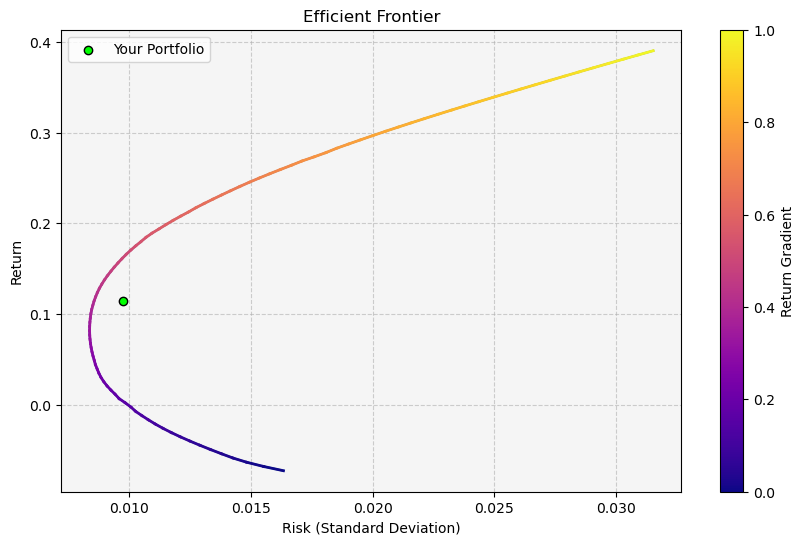

In [57]:
# 6. (Extra 10 points) Visualize your results by plotting the efficient frontier, and the positions of each
# asset and the portfolio.
import matplotlib.pyplot as plt
import matplotlib.cm as cm

plt.figure(figsize=(10, 6))
# plt.plot(efficient_frontier[:, 1], efficient_frontier[:, 0], label='Efficient Frontier')
plt.plot(efficient_frontier[:, 1], efficient_frontier[:, 0],label='_nolegend_')
plt.scatter(portfolio_std_dev, portfolio_return, color='lime', edgecolor='black', label='Your Portfolio', zorder=5)
plt.gca().set_facecolor('whitesmoke')
colors = cm.plasma(np.linspace(0, 1, len(efficient_frontier)))
for i in range(len(efficient_frontier) - 1):
    plt.plot(
        [efficient_frontier[i, 1], efficient_frontier[i + 1, 1]],
        [efficient_frontier[i, 0], efficient_frontier[i + 1, 0]],
        color=colors[i],
        linewidth=2,
    )

plt.xlabel('Risk (Standard Deviation)')
plt.ylabel('Return')
plt.title('Efficient Frontier')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.colorbar(cm.ScalarMappable(cmap='plasma'), label="Return Gradient")
plt.show()